# Word Cloud for a Miner's Day 

1. Import libraries
2. Paths
3. Read IRiESP* 
4. Data Cleaning
5. Lemmatisation
6. Word Cloud

*IRiESP is polish version of Transmission Network Code (TNC)

### Import libraries

In [1]:
# Read pdf
from io import StringIO
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage

In [2]:
# Data Cleaning 
import numpy as np
import pandas as pd
import string

In [3]:
# Lemmatisation
from pyMorfologik import Morfologik
from pyMorfologik.parsing import ListParser
import json

In [4]:
# Word Cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
#import numpy as np

### Paths

In [5]:
path = ''

In [6]:
# IRiESP
# download: http://www.gaz-system.pl/strefa-klienta/iriesp/instrukcja-ruchu-i-eksploatacji-sieci-przesylowej/  
iriesp = path + 'IRiESPv25.pdf'

In [7]:
# stopwords
# download: https://github.com/stopwords-iso/stopwords-pl 
stopwords_pl_txt = path + 'stopwords-pl.txt' 

In [8]:
# my gas dictionaries (json)
gas_dict_1 = path + 'gas_dict_1.txt'
gas_dict_2 = path + 'gas_dict_2.txt'

In [9]:
# path for wordclouds
image_1 = path + 'symbol_of_mining.png'
image_2_python = path + 'symbol_of_mining_python.png'

### Reading IRiESP

In [10]:
def read_pdf(fname):
    
    # initiating the Interpreter class as a text reader
    output = StringIO()             # creates a string buffer
    manager = PDFResourceManager()  # initiating the resource manager class
    laparams = LAParams()           # initiating the layout class
    codec = 'utf-8'                 
    
    device = TextConverter(manager, output, laparams=laparams, codec=codec)
    interpreter = PDFPageInterpreter(manager, device)
    
    # extracting the pages from the pdf file
    infile = open(fname, 'rb')
    pages = PDFPage.get_pages(infile, check_extractable=True)
 
    for page in pages:
        interpreter.process_page(page)
 
    text = output.getvalue()
    
    infile.close()
    device.close()   
    output.close()
    
    return text

#### Assessing the contents

In [11]:
file_contents = read_pdf(iriesp)

In [12]:
iriesp_words = file_contents.split()
print("IRiESP contains ", len(iriesp_words), " words")

IRiESP contains  45918  words


### Data Cleaning

In [13]:
def clean_data(words):
    
    # removing punctuation
    string_punctuation_my = string.punctuation + '„' + '”' + '“'
    string_punctuation_my = string_punctuation_my.replace('-','')
    
    table = str.maketrans({key: None for key in string_punctuation_my})
    words[:] = [value.translate(table) for value in words]

    # removing specific words
    words_footer = ['Strona', 'Wersja', '∆pi']
    words = list(filter(lambda x: x not in set(words_footer), words))

    # removing numbers
    words[:] = [value for value in words if not any(c.isdigit() for c in value)] 

    # transformation the text into lowercase
    words[:] = [value.lower() for value in words]

    # removing stopwords_pl
    with open(stopwords_pl_txt) as f:
        stopwords_pl_data = f.readlines()
    stopwords_pl_data = [con_word.strip('\n') for con_word in stopwords_pl_data]
    stopwords_pl_data = [value.lower() for value in stopwords_pl_data]
    words[:] = list(filter(lambda x: x not in stopwords_pl_data, words))

    words = list(filter(None, words))

    # removing small words
    words[:] = [value for value in words if len(value)>2 or (value == 'lw')]  

    return words

In [14]:
iriesp_words = clean_data(iriesp_words)

#### Counting the frequency of occurrence of words

In [15]:
unique, counts = np.unique(iriesp_words, return_counts=True)
data_iriesp_words = np.ndarray((len(unique),2), dtype=object)
data_iriesp_words[:,0] = unique
data_iriesp_words[:,1] = counts

df_iriesp_words = pd.DataFrame(data_iriesp_words, columns=['word', 'count'])
df_iriesp_words = df_iriesp_words.sort_values(by='count', ascending=False)

### Lemmatisation

#### Morfologik

In [16]:
word_d = dict()
for i in range(len(df_iriesp_words)):
    w_i = Morfologik().stem([df_iriesp_words.iloc[i,0]], ListParser())
    try:
        word_d_i = dict([(w_i[0][0], list(w_i[0][1].keys())[0])]) 
        word_d.update(word_d_i)
    except IndexError:
        word_d_i = dict([(w_i[0][0], 'NULL')])
        word_d.update(word_d_i)
        
df_iriesp_words_1 = pd.DataFrame(list(word_d.items()), columns=['word_old', 'word_new'])

#### Gas vocabulary

In [17]:
# converting gas_dict_2 to data frame

def convert_dict_to_df(dict_2): 
    
    values_list = list()
    keys_list = list()
    for word_base, words in dict_2.items():    
        for i in range(len(words)):
            values_list.append(words[i])
            keys_list.append(word_base)
    dict_df = pd.DataFrame(list(zip(values_list,keys_list)), columns=['word_old','word_new'])    
    
    return dict_df

In [18]:
def corect_gas_words(dict_1, dict_2, df):

    f1 = open(dict_1, 'r')
    d1 = json.loads(f1.read())
    d1_1 = [value.lower() for value in d1]
    f1.close()
    
    f2 = open(dict_2, 'r')
    d2 = json.loads(f2.read())
    d2_df = convert_dict_to_df(d2)
    f2.close()
    
    df_2 = df
    for i in range(len(df)):
        if df.word_old[i] in d1_1:
            df_2.word_new[i] = d1[d1_1.index(df.word_old[i])]
        elif df.word_old[i] in list(d2_df['word_old']):       
            df_2.word_new[i] = d2_df.word_new[d2_df.index[d2_df.word_old == df.word_old[i]].tolist()[0]] 
        else:
            df_2.word_new[i] = df.word_new[i] 
    
    return df_2

In [19]:
df_iriesp_words_2 = corect_gas_words(gas_dict_1, gas_dict_2, df_iriesp_words_1)

#### Adding frequency

In [20]:
df_iriesp_words_2 = pd.merge(df_iriesp_words_2, df_iriesp_words, 
                             how='left', left_on='word_old', right_on='word')
df_iriesp_words_2 = df_iriesp_words_2[['word_new', 'count']]
df_iriesp_words_2 = df_iriesp_words_2[df_iriesp_words_2['word_new'] != 'NULL']

df_iriesp_words_2 = df_iriesp_words_2.groupby('word_new', as_index=False)
df_iriesp_words_2 = pd.DataFrame(df_iriesp_words_2['count'].sum())
df_iriesp_words_2 = df_iriesp_words_2.sort_values(by='count', ascending=False)

df_iriesp_words_2 = df_iriesp_words_2.reset_index(drop=True)
df_iriesp_words_2 = df_iriesp_words_2.rename(columns={'word_new': 'word'})

In [21]:
#df_iriesp_words_2.to_csv(path + 'words_df_iriesp.csv', index=False, sep=',', encoding='utf-8')

In [22]:
#df_iriesp_words_2 = pd.read_csv(path + 'words_df_iriesp.csv', sep=',', encoding='utf-8')

In [23]:
df_iriesp_words_2.head(10)

,word,count
0,punkt,1149
1,przesyłowy,929
2,gazowy,890
3,OSP,774
4,system,676
5,paliwo,635
6,przepustowość,455
7,sieć,423
8,fizyczny,321
9,wyjście,317


### Word Cloud

In [24]:
comment_words = ' ' 
for val in df_iriesp_words_2.word: 
    val = str(val) 
    tokens = val.split()           
    for words in tokens: 
        comment_words = comment_words + words + ' '

In [25]:
d = {}
for a, x in df_iriesp_words_2.values:
    d[a] = x

In [26]:
black_color = (0,0,0)
gold_color_func = lambda *args, **kwargs: (255,215,0)   #'rgb(255,215,0)'

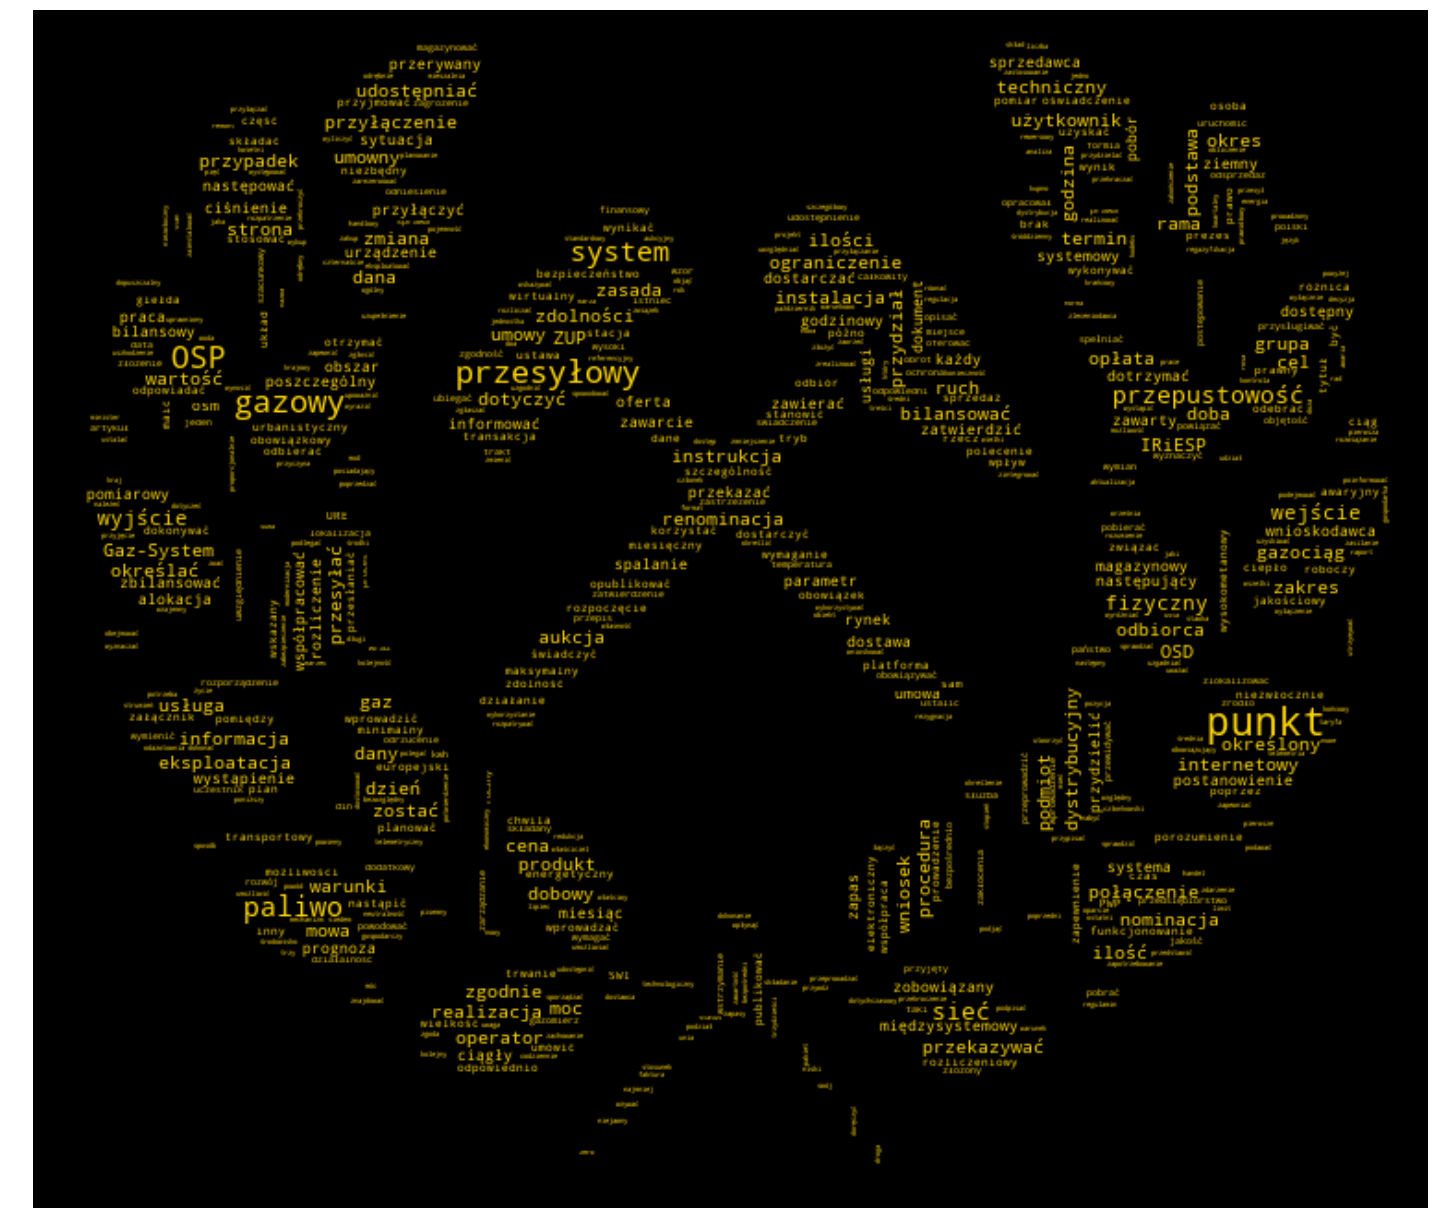

In [27]:
# Generating a word cloud image
mask = np.array(Image.open(image_1))
wordcloud_image_1 = WordCloud(background_color=black_color, 
                              max_words=1000, mask=mask, 
                              prefer_horizontal=0.9, 
                              margin=2).generate(comment_words)
wordcloud_image_1.generate_from_frequencies(frequencies=d)

plt.figure(figsize=[25,25])
plt.imshow(wordcloud_image_1.recolor(color_func=gold_color_func),
           interpolation="bilinear")
plt.axis("off")

plt.savefig(image_2_python, format="png")
plt.show()